In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 13

import keras
from keras.optimizers import Adam, RMSprop, Nadam, SGD
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten #, Reshape
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, AveragePooling1D

2024-03-09 12:20:14.657993: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-09 12:20:15.521535: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Section 0

### Read data

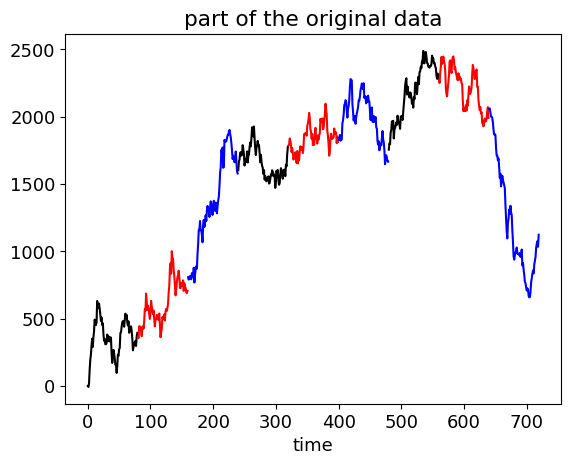

data:  4000


In [2]:
def Show_data(x,L,s="data",T=3):
    c=("k","r","b")
    for i in range(T):
        j=i*3*L
        plt.plot(np.arange(j,j+L),x[i*3],c=c[0])
        plt.plot(np.arange(j+L,j+2*L),x[i*3+1],c=c[1])
        plt.plot(np.arange(j+2*L,j+3*L),x[i*3+2],c=c[2])
    plt.title(s)
    plt.xlabel("time")
    plt.show()
    
str0="ts_L80_N4000.dat"
fnamex='x_'+str0
fnamey='y_'+str0

x = np.loadtxt(fnamex, delimiter=" ",dtype=float)
N,L = len(x), len(x[0])

Show_data(x,L,"part of the original data")

categ = np.loadtxt(fnamey, dtype=int)
n_class = 3    # y.argmax() - y.argmin() +1
print('data: ',N)

y = np.zeros((N,n_class))
for i in range(N):
    y[i][categ[i]] = 1.

### Rescale data, split train/val.

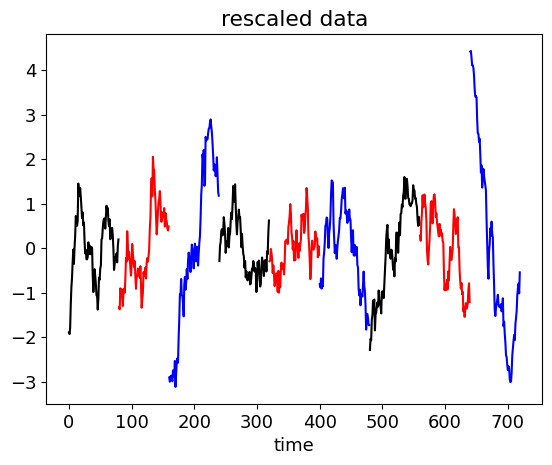

N_train= 3200   N_val= 800   L= 80   n_class= 3


In [3]:
#
#  FIRST PASSAGE:  DO NOT DO THIS --> FAILURE 
#
# bring each sample to zero average
xm = x.mean(axis=1)
for i in range(N):
    x[i] = x[i]-xm[i]

#
#  SECOND PASSAGE:  DO NOT DO THIS --> ALSO FAILURE 
#
#rescale (crude version, variance should be used)
x = x / x.std()
    
Show_data(x,L,"rescaled data")

perc_train=0.8
N_train = int(perc_train*N)
x_train = x[:N_train]
y_train = y[:N_train]
x_val = x[N_train:]
y_val = y[N_train:]
N_val = len(x_val)
print('N_train=',N_train,'  N_val=',N_val,'  L=',L,'  n_class=',n_class)

# Keras wants an additional dimension with a 1 at the end
x_train = x_train.reshape(x_train.shape[0], L, 1)
x_val =  x_val.reshape(x_val.shape[0], L, 1)
input_shape = (L, 1)

## Convolutional NN

In [4]:
# ...LESSON ...
# reproducibility
np.random.seed(12345)
import tensorflow.random as tf_r
tf_r.set_seed(12345)

NCONV=2

def build_model(NCONV=1, NF=5,KS=6, NF2=5,KS2=4, lamb=0):
    """
    filter = kernel
    NCONV=index of the CNN architecture
    NF=nr of filters in the 1st layer
    KS=kernel size in the 1st layer
    NF2=nr of filters in the 2nd layer
    KS2=kernel size in the 2nd layer
    lamb=not the animal, but lambda, the regularization parameter
    """
    # regularizers, l2=Ridge, l1=LASSO
    reg = keras.regularizers.l2(lamb)
    model = Sequential()

    # Version with last layer Dense
    if NCONV==1:
        model.add(Conv1D(filters=NF, 
                         kernel_size=KS,
                         kernel_regularizer=reg,
                         activation='relu', 
                         input_shape=input_shape))
        model.add(MaxPooling1D(3))
        #model.add(AveragePooling1D(3))
        model.add(Conv1D(filters=NF2, kernel_size=KS2,activation='relu'))
        model.add(Flatten())
        model.add(Dense(12, activation='relu'))
        model.add(Dropout(0.2))

    # Version with last layer GlobalMaxPooling, one more intermediate conv1D, and no intermediate pooling
    if NCONV==2:
        model.add(Conv1D(filters=NF, 
                         kernel_size=KS,
                         kernel_regularizer=reg,
                         activation='relu', 
                         input_shape=input_shape))
        model.add(Conv1D(filters=NF2, kernel_size=KS2,activation='relu'))
        model.add(Conv1D(filters=NF2, kernel_size=KS2,activation='relu'))
        model.add(tf.keras.layers.GlobalMaxPooling1D())
        model.add(Flatten())
        
    # Last layer, with n_class units  
    model.add(Dense(n_class, activation='softmax')) # softmax !
    
    # optimizers
    # .SGD(lr=0.01, momentum=0.9, nesterov=True) # decay=1e-6,
    # .Adam()
    # .RMSprop()
    # .Nadam()
    # Define the optimizer learning rate as a hyperparameter.
    opt = keras.optimizers.RMSprop()
    
    # compile the model
    # categorical_crossentropy, 3 output nodes
    model.compile(loss=keras.losses.categorical_crossentropy,optimizer=opt,metrics=['accuracy'])
    return model

model=build_model(NCONV=NCONV,KS=11)


print('----- Model',NCONV,'-----')
print(model.summary())

# optimizers
# .SGD(lr=0.01, momentum=0.9, nesterov=True) # decay=1e-6,
# .RMSprop()
# .Nadam()
opt = tf.keras.optimizers.Adam()

# compile the model
# categorical_crossentropy, 3 output nodes
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=opt,metrics=['accuracy'])

print(model.layers)

----- Model 2 -----


/home/ubuntu/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 70, 5)          │            60 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 67, 5)          │           105 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 64, 5)          │           105 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 5)              │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 288 (1.12 KB)

 Trainable params: 288 (1.12 KB)

 Non-trainable params: 0 (0.00 B)

None
[<Conv1D name=conv1d, built=True>, <Conv1D name=conv1d_1, built=True>, <Conv1D name=conv1d_2, built=True>, <GlobalMaxPooling1D name=global_max_pooling1d, built=True>, <Flatten name=flatten, built=True>, <Dense name=dense, built=True>]


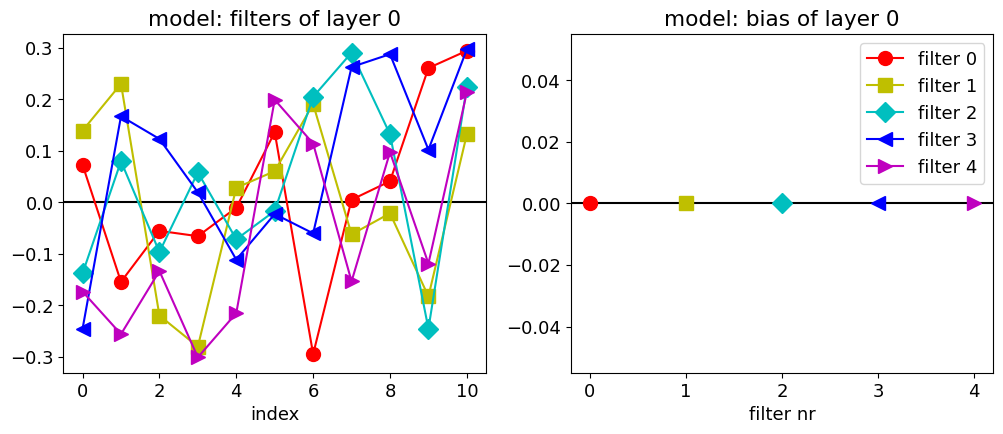

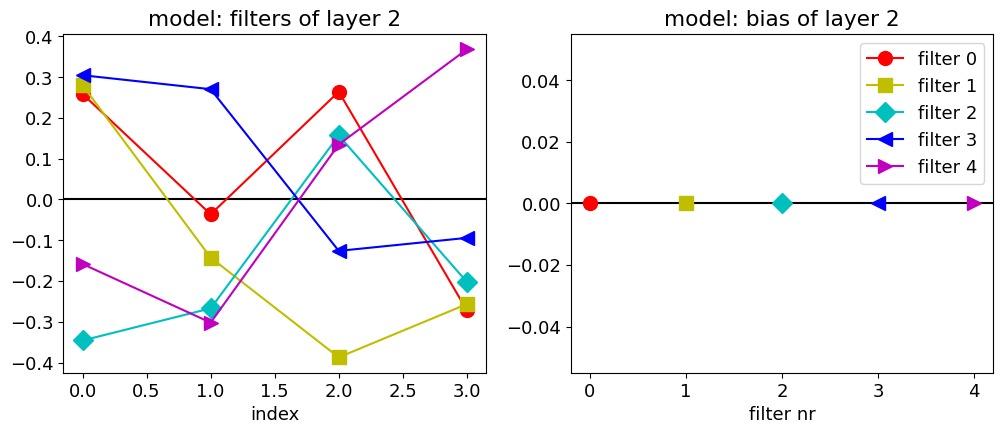

In [5]:
def Show_weights(model,l=0,label="model"):
    c=['r','y','c','b','m','k',"gray","cyan","g"]
    m=['o','s','D','<','>','^','+','x','d',"*"]
    ms=10
    
    w = model.layers[l].get_weights()[0]
    wT=w.T
    M=len(wT)
    #print(M)
    b = model.layers[l].get_weights()[1]
    
    fig,AX=plt.subplots(1,2,figsize=(12,4.4))
    ax=AX[0]
    ax.axhline(0, c="k")
    ax.plot((0,))
    for i in range(M):
        ax.plot(wT[i][0],"-",c=c[i%len(c)],marker=m[i%len(m)],label=str(i),markersize=ms)

    print()
    
    ax.set_title(label+': filters of layer '+str(l))
    ax.set_xlabel('index')
    ax=AX[1]
    ax.axhline(0, c="k")
    for i in range(M):
        ax.plot((i),(b[i]),c=c[i%len(c)],marker=m[i%len(m)],label="filter "+str(i),markersize=ms)
    ax.set_title(label+': bias of layer '+str(l))
    ax.set_xlabel('filter nr')
    ax.set_xticks(np.arange(5))
    ax.legend()
    plt.show()
    
Show_weights(model,0)
Show_weights(model,2)

In [6]:
# ...LESSON ...
# Hyper-parameters
# with small minibatch it does not converge!! 
BATCH_SIZE = 200
EPOCHS = 300

print('----- Model ',NCONV,'-----\nFITTING....')
fit = model.fit(x_train,y_train,batch_size=BATCH_SIZE,
                epochs=EPOCHS,
                validation_data=(x_val, y_val),
                verbose=2, shuffle=True) 
print("end of fit")

----- Model  2 -----
FITTING....
Epoch 1/300
16/16 - 1s - 58ms/step - accuracy: 0.3819 - loss: 1.0969 - val_accuracy: 0.3850 - val_loss: 1.0866
Epoch 2/300
16/16 - 0s - 6ms/step - accuracy: 0.3656 - loss: 1.0834 - val_accuracy: 0.3537 - val_loss: 1.0756
Epoch 3/300
16/16 - 0s - 9ms/step - accuracy: 0.3650 - loss: 1.0717 - val_accuracy: 0.3613 - val_loss: 1.0643
Epoch 4/300
16/16 - 0s - 8ms/step - accuracy: 0.4078 - loss: 1.0594 - val_accuracy: 0.4038 - val_loss: 1.0511
Epoch 5/300
16/16 - 0s - 11ms/step - accuracy: 0.4538 - loss: 1.0451 - val_accuracy: 0.4275 - val_loss: 1.0367
Epoch 6/300
16/16 - 0s - 8ms/step - accuracy: 0.4756 - loss: 1.0298 - val_accuracy: 0.4588 - val_loss: 1.0215
Epoch 7/300
16/16 - 0s - 7ms/step - accuracy: 0.4906 - loss: 1.0135 - val_accuracy: 0.4787 - val_loss: 1.0067
Epoch 8/300
16/16 - 0s - 7ms/step - accuracy: 0.5094 - loss: 0.9976 - val_accuracy: 0.5025 - val_loss: 0.9912
Epoch 9/300
16/16 - 0s - 6ms/step - accuracy: 0.5147 - loss: 0.9821 - val_accuracy: 0

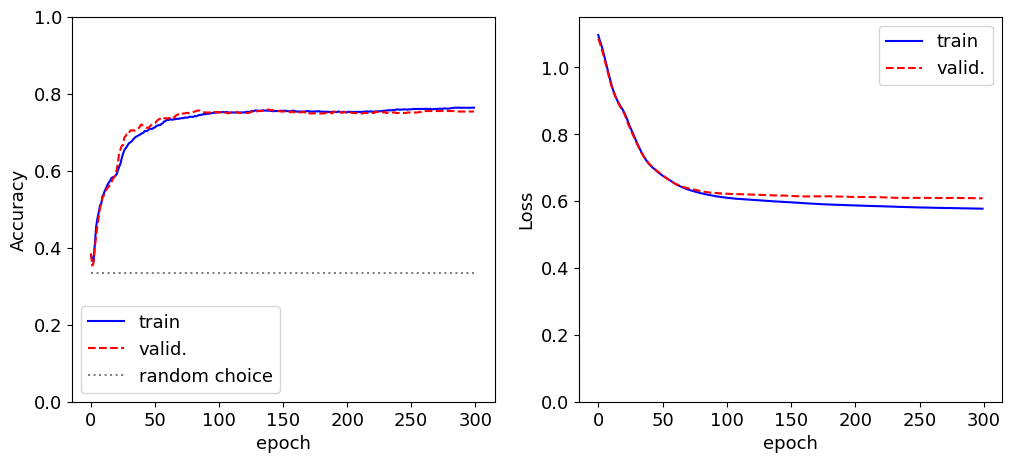

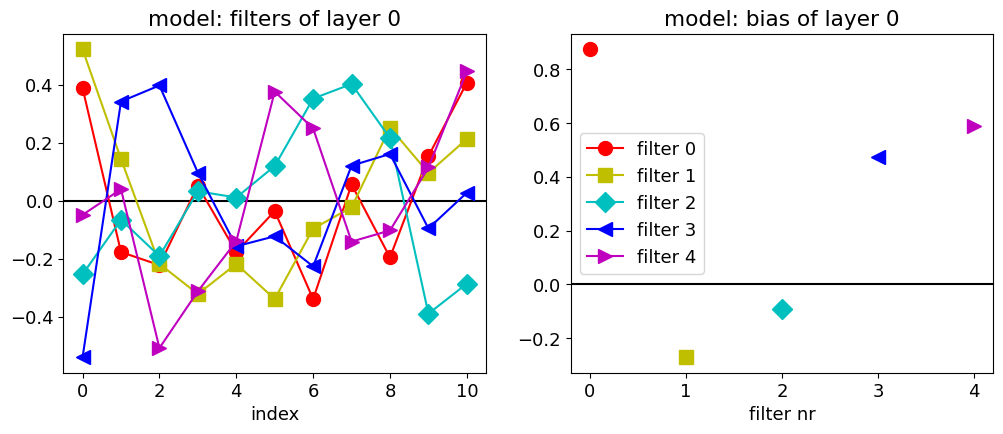

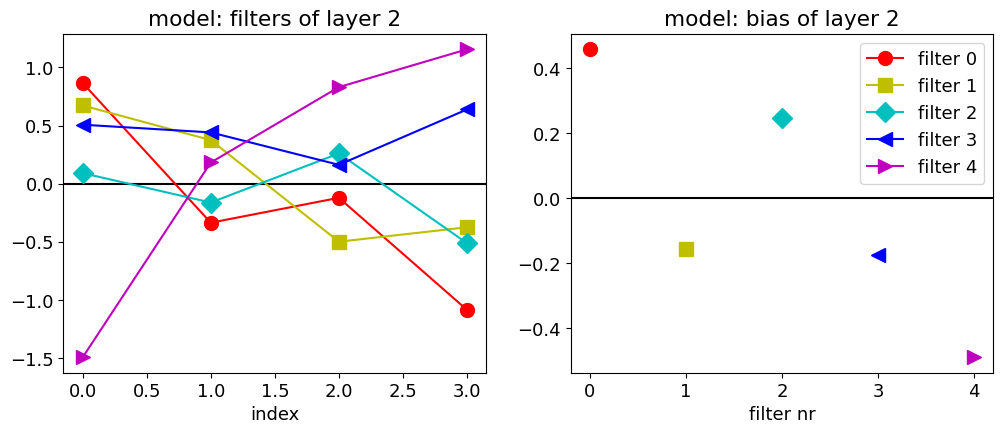

In [7]:
def Show_history(fit):
    fig,AX=plt.subplots(1,2,figsize=(12,5.))
    ax=AX[0]
    ax.plot(fit.history['accuracy'],"b",label="train")
    ax.plot(fit.history['val_accuracy'],"r--",label="valid.")
    ax.plot((0,EPOCHS),(1/3,1/3),":",c="gray",label="random choice")
    ax.set_xlabel('epoch')
    ax.set_ylabel("Accuracy")
    ax.set_ylim([0, 1])
    ax.legend()
    ax=AX[1]
    ax.plot(fit.history['loss'],"b",label="train")
    ax.plot(fit.history['val_loss'],"r--",label="valid.")
    ax.set_xlabel('epoch')
    ax.set_ylabel("Loss")
    ax.set_ylim([0, 1.05*np.max(fit.history['loss'])])
    ax.legend()
    plt.show()
Show_history(fit)
Show_weights(model,0)
Show_weights(model,2)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step


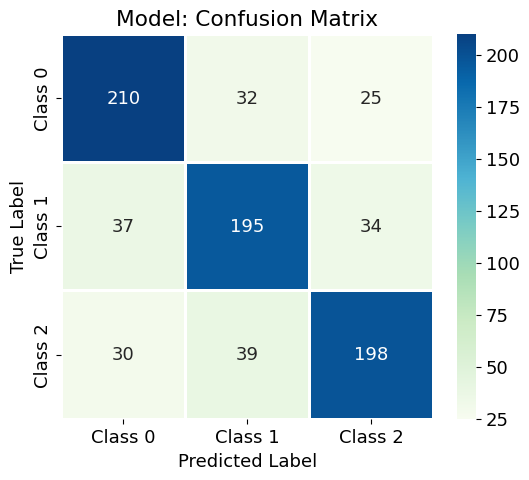

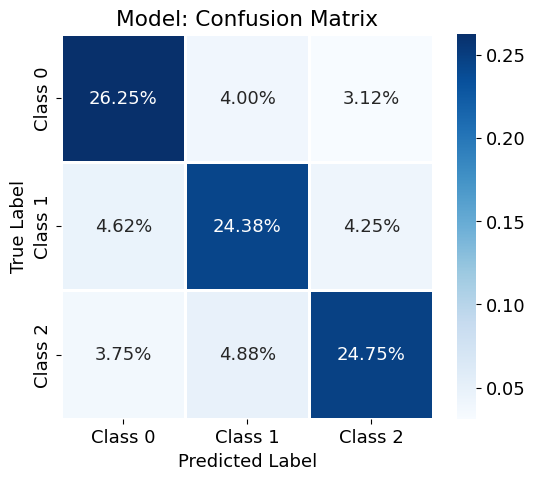

In [8]:
import pandas as pd
from scipy import stats

import seaborn 
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

LABELS = ["Class 0","Class 1","Class 2"]

def show_confusion_matrix(validations, predictions, label="Model",perc=False):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 5))
    M = matrix
    f = 'd'
    cmap="GnBu"
    if perc:
        M=M/np.sum(M)
        f='.2%'
        cmap='Blues'
    seaborn.heatmap(M,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt=f,
                linecolor='white',
                linewidths=1,
                cmap=cmap)
    plt.title(label+': Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

y_pred_val = np.array(model.predict(x_val))
# Take the class with the highest probability from the val predictions
max_y_pred_val = np.argmax(y_pred_val, axis=1)
max_y_val = np.argmax(y_val, axis=1)

show_confusion_matrix(max_y_val, max_y_pred_val)
show_confusion_matrix(max_y_val, max_y_pred_val,perc=True)

In [10]:
model2 = keras.models.clone_model(model)

reg2 = keras.regularizers.l2(0.5)
model2.layers[0].kernel_regularizer = reg2
model2.layers[1].kernel_regularizer = reg2
model2.layers[2].kernel_regularizer = reg2

opt = tf.keras.optimizers.Adam()
model2.compile(loss=keras.losses.categorical_crossentropy,optimizer=opt,metrics=['accuracy'])

BATCH_SIZE2 = 200
EPOCHS2 = 300

fit2 = model2.fit(x_train,y_train,batch_size=BATCH_SIZE2,epochs=EPOCHS2,
                validation_data=(x_val, y_val), verbose=2, shuffle=True) 

Epoch 1/300
16/16 - 1s - 65ms/step - accuracy: 0.3681 - loss: 1.1137 - val_accuracy: 0.3775 - val_loss: 1.0926
Epoch 2/300
16/16 - 0s - 6ms/step - accuracy: 0.3719 - loss: 1.0832 - val_accuracy: 0.3738 - val_loss: 1.0838
Epoch 3/300
16/16 - 0s - 6ms/step - accuracy: 0.3841 - loss: 1.0776 - val_accuracy: 0.3963 - val_loss: 1.0763
Epoch 4/300
16/16 - 0s - 5ms/step - accuracy: 0.4031 - loss: 1.0710 - val_accuracy: 0.4062 - val_loss: 1.0704
Epoch 5/300
16/16 - 0s - 9ms/step - accuracy: 0.4187 - loss: 1.0643 - val_accuracy: 0.4050 - val_loss: 1.0638
Epoch 6/300
16/16 - 0s - 6ms/step - accuracy: 0.4250 - loss: 1.0570 - val_accuracy: 0.4025 - val_loss: 1.0566
Epoch 7/300
16/16 - 0s - 5ms/step - accuracy: 0.4359 - loss: 1.0490 - val_accuracy: 0.4187 - val_loss: 1.0496
Epoch 8/300
16/16 - 0s - 5ms/step - accuracy: 0.4416 - loss: 1.0411 - val_accuracy: 0.4250 - val_loss: 1.0426
Epoch 9/300
16/16 - 0s - 5ms/step - accuracy: 0.4512 - loss: 1.0331 - val_accuracy: 0.4275 - val_loss: 1.0350
Epoch 10/

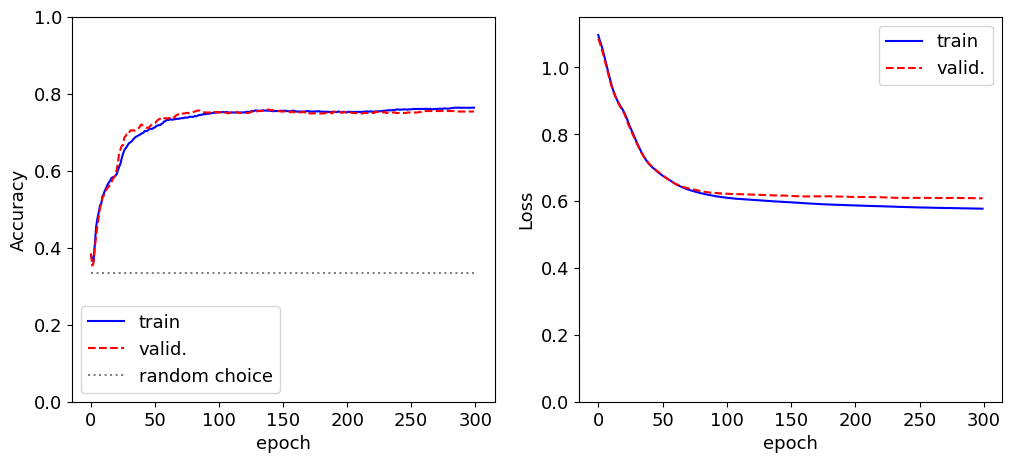

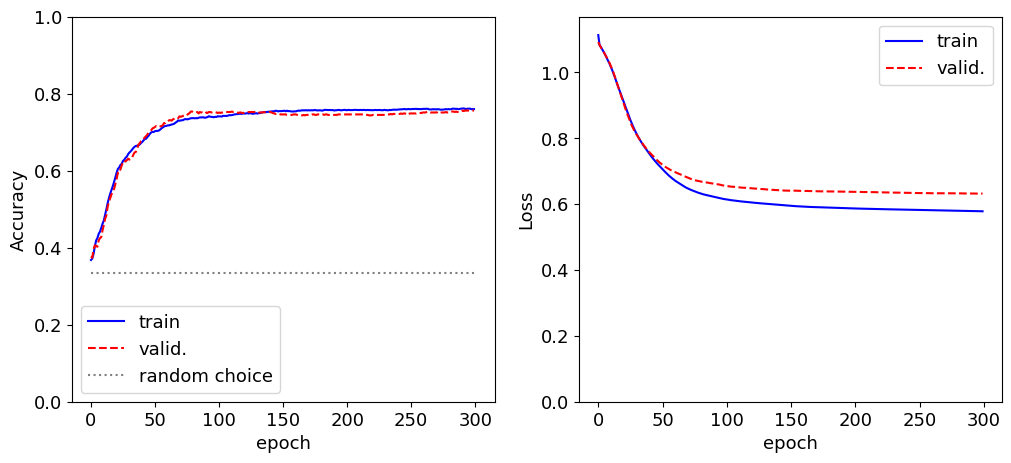

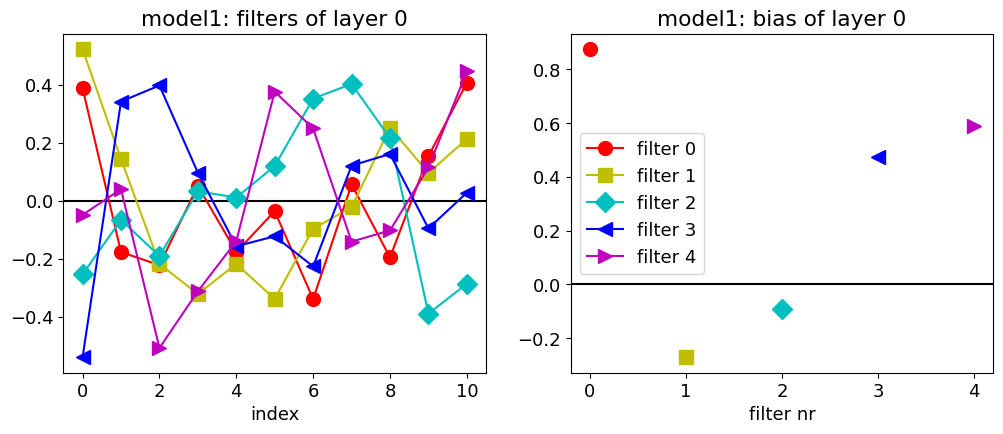

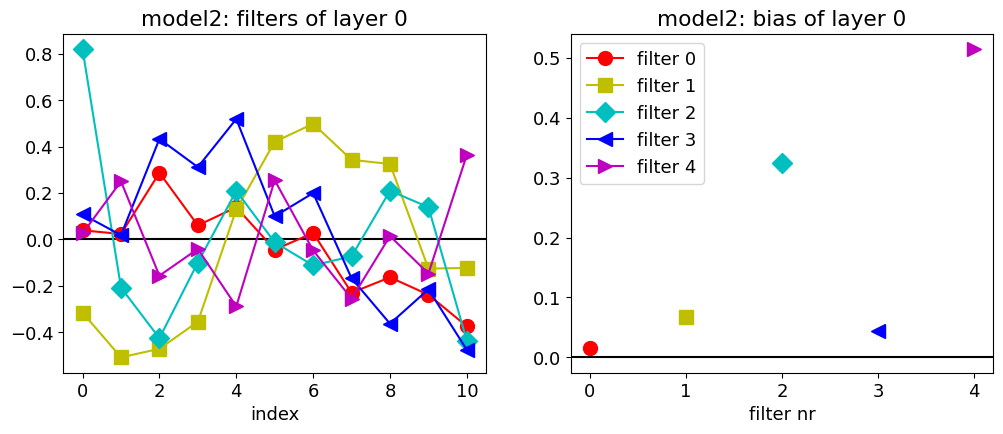

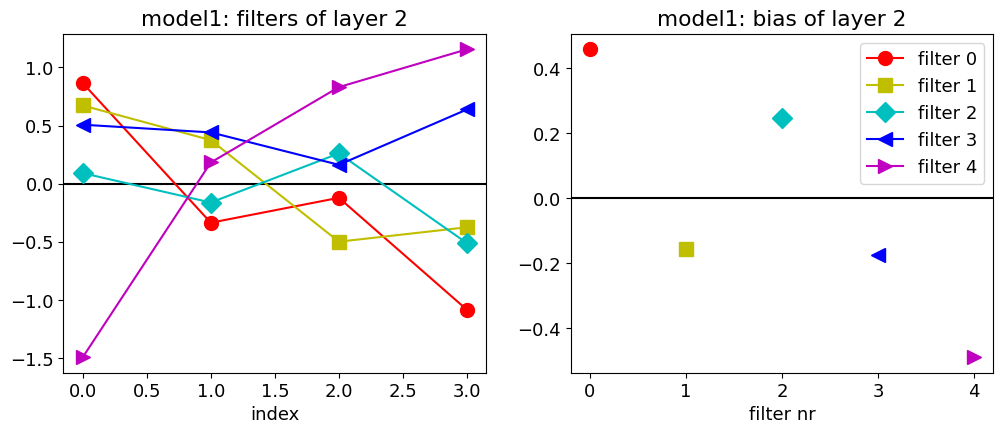

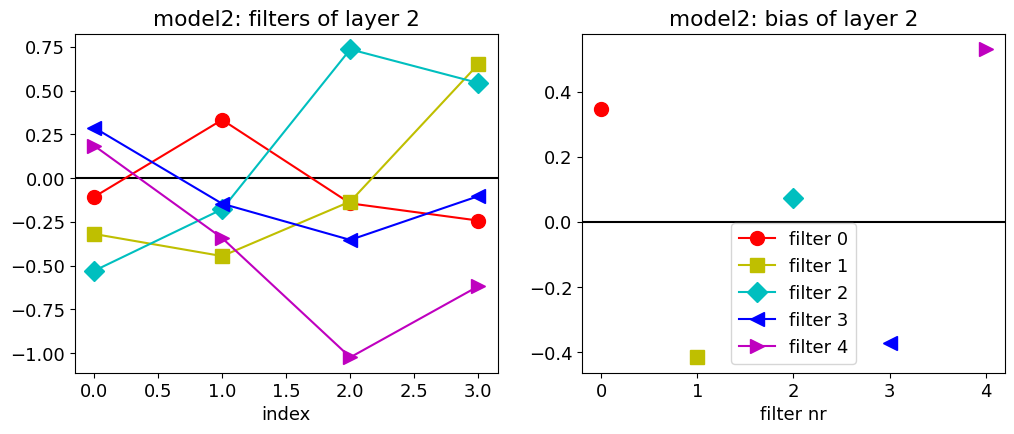

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step


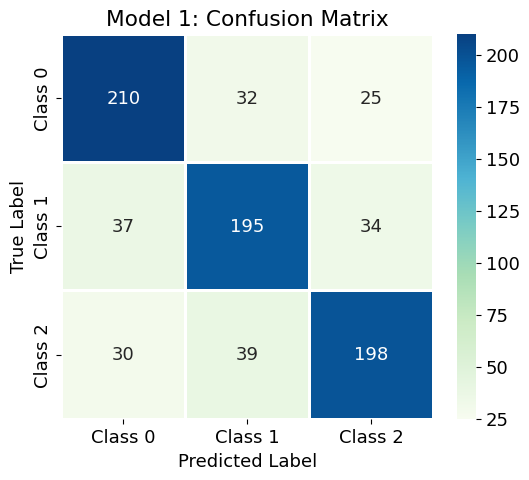

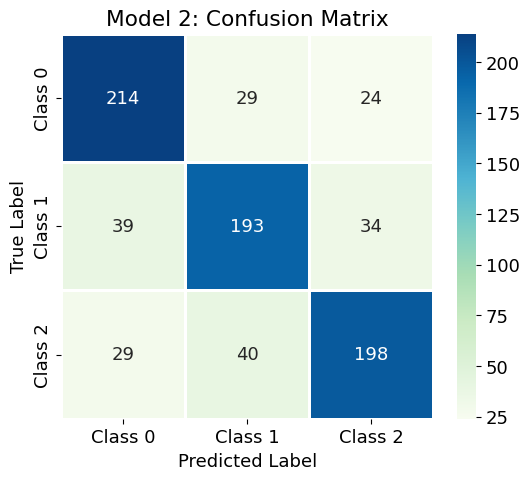

In [11]:
Show_history(fit)
Show_history(fit2)

Show_weights(model,0,label="model1")
Show_weights(model2,0,label="model2")
Show_weights(model,2,label="model1")
Show_weights(model2,2,label="model2")


y_pred_val2 = model2.predict(x_val)
# Take the class with the highest probability from the val predictions
max_y_pred_val2 = np.argmax(y_pred_val2, axis=1)

show_confusion_matrix(max_y_val, max_y_pred_val, label="Model 1")
show_confusion_matrix(max_y_val, max_y_pred_val2, label="Model 2")

# Section 1

As regard to the first point of the exercises, on the basis of the obtained results we chose the CNN version ending with a global max pooling layer (G). It can indeed be observed, from the available plots of training and validation errors through the $300$ epochs, that overfitting appears to occur with and without regularization. For the G version, instead, the training and validation accuracies are very similar, and the regularization term introduces smoothing of the relative curves.

# Section 2

In [12]:
def plot_models(opts):
    
    N_fits = 5
    
    for o in opts:
        for _ in range(N_fits):
            
            model=build_model(NCONV=2,KS=11)
            model.compile(loss=keras.losses.categorical_crossentropy, optimizer = o, metrics = ['accuracy'])
    
            BATCH_SIZE = 200
            EPOCHS = 50
    
            fit = model.fit(x_train,y_train,batch_size=BATCH_SIZE,epochs=EPOCHS,validation_data=(x_val, y_val), verbose=1, shuffle=True)
    
            Show_history(fit)

In [13]:
import time 

def get_optimizer(optimizer_type, learning_rate):
    if optimizer_type.lower() == 'adam':
        return Adam(learning_rate = learning_rate)
    
    if optimizer_type.lower() == 'rmsprop':
        return RMSprop(learning_rate=learning_rate)
    
    if optimizer_type.lower() == 'nadam':
        return Nadam(learning_rate=learning_rate)
    
    if optimizer_type.lower() == 'sgd':
        return SGD(learning_rate=learning_rate)
    


/home/ubuntu/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


OPTIMIZER:  ADAM
Learning rate: 0.00050 (Run: 1)
---------------------------------------
Iteration number:  1 of 100
Remaining time:  40.08 min
Learning rate: 0.00050 (Run: 2)
---------------------------------------
Iteration number:  2 of 100
Remaining time:  39.27 min
Learning rate: 0.00050 (Run: 3)
---------------------------------------
Iteration number:  3 of 100
Remaining time:  38.44 min
Learning rate: 0.00050 (Run: 4)
---------------------------------------
Iteration number:  4 of 100
Remaining time:  37.51 min
Learning rate: 0.00050 (Run: 5)
---------------------------------------
Iteration number:  5 of 100
Remaining time:  36.61 min
Validation accuracy and std:  [[0.7537500143051148, 0.01429597420278408]]
Learning rate: 0.00287 (Run: 1)
---------------------------------------
Iteration number:  6 of 100
Remaining time:  35.69 min
Learning rate: 0.00287 (Run: 2)
---------------------------------------
Iteration number:  7 of 100
Remaining time:  34.76 min
Learning rate: 0.002

<Figure size 2000x500 with 0 Axes>

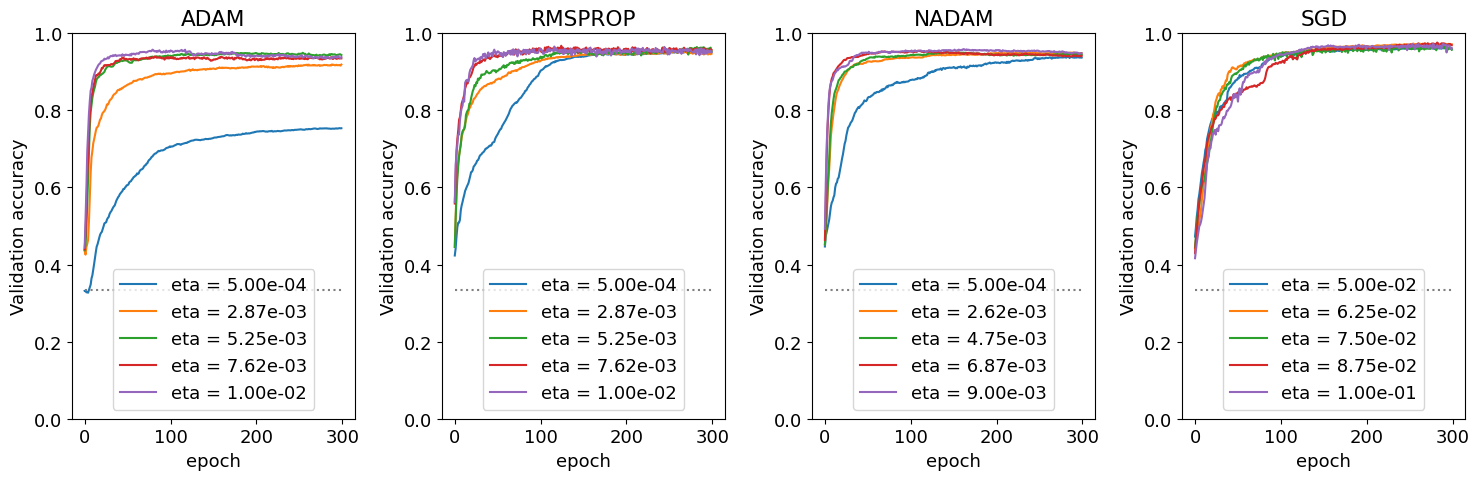

In [14]:
OPTIMIZERS = ['adam', 'rmsprop', 'nadam', 'sgd']

BATCH_SIZE = 200
EPOCHS = 300

N_run = 5
fig = plt.figure(figsize = (20,5))
model=build_model(NCONV=2,KS=11)


fig = plt.figure(figsize = (15, 5))

val_tot = np.zeros(EPOCHS)
etas_tot = [np.linspace(0.0005, 0.01, 5), np.linspace(0.0005, 0.01, 5), np.linspace(0.0005, 0.009, 5), np.linspace(0.05, 0.1, 5)] #imposto questo valore per ora 

ACCURACY = {}
num_iter = len(OPTIMIZERS) * 5 * len(etas_tot[0])
counter = 1

start = time.time()
count_time = 0

for j, opt_ in enumerate(OPTIMIZERS):
    print('OPTIMIZER: ', opt_.upper())
    ax = fig.add_subplot(1, 4, j + 1)
    
    ACCURACY[opt_] = []
    
    for k, e in enumerate(etas_tot[j]):
        mean = 0
        STD = []
        
        for i in range(N_run):
            model_i = keras.models.clone_model(model)
            opt = get_optimizer(opt_, learning_rate=e)

            model_i.compile(loss=keras.losses.categorical_crossentropy, optimizer = opt, metrics = ['accuracy'])
            fit = model_i.fit(x_train,y_train,batch_size=BATCH_SIZE,epochs=EPOCHS,validation_data=(x_val, y_val), verbose=0, shuffle=True)
        
            val_tot += np.array(fit.history['val_accuracy'])
            print(f"Learning rate: {e:.5f} (Run: {i+1})")
            
            print('---------------------------------------')
            print('Iteration number: ', counter, 'of', num_iter )

            mean += fit.history['val_accuracy'][-1]
            STD.append(fit.history['val_accuracy'][-1])

            counter += 1
            if count_time == 0:
               stop = time.time() 
               total_time = stop - start 
               count_time += 1
            
            vu =( total_time * 100 - 2 * ( time.time() - start )  ) / 60

            print(f'Remaining time:  {vu:.2f} min')

        ACCURACY[opt_].append([mean / N_run, np.std(STD)])   
        print('Validation accuracy and std: ', ACCURACY[opt_])
        val_tot = [v / N_run for v in val_tot]

        ax.plot(val_tot,label=f"eta = {e:.2e}")
    
    count_time = 0
    
    ax.plot((0,EPOCHS),(1/3,1/3),":",c="gray")
    ax.set_title(opt_.upper())
    ax.set_xlabel('epoch')
    ax.set_ylabel("Validation accuracy")
    ax.set_ylim([0, 1])
    ax.legend()

plt.tight_layout()
plt.show()

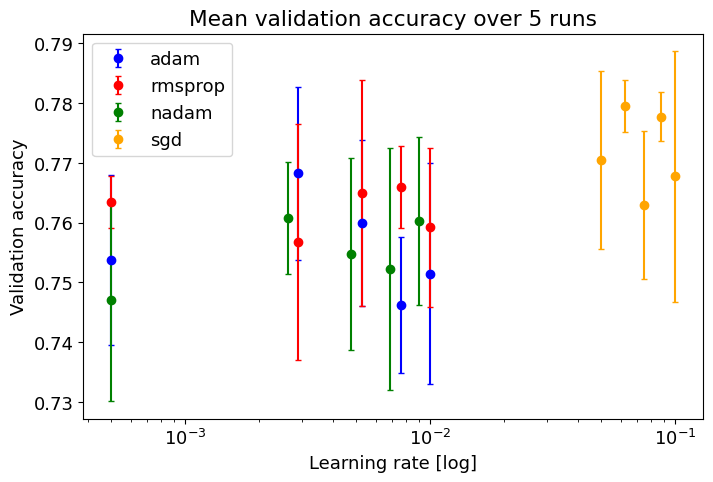

In [15]:
index = np.linspace(1, 20, 20)
colors = ['blue', 'red', 'green', 'orange']

figure = plt.figure(figsize = (8, 5))
ax = figure.add_subplot(111)
t = 1
for k, i in enumerate(ACCURACY):
    element = ACCURACY[i]
    eta = etas_tot[k]    
    ax.errorbar(eta[0], element[0][0], yerr = element[0][1], c = colors[k], label = OPTIMIZERS[k], capsize = 2, fmt = 'o')

    for j in range(1, len(eta)):
       ax.errorbar(eta[j], element[j][0], yerr = element[j][1], c = colors[k], capsize = 2, fmt = 'o')
       t += 1

ax.set_title("Mean validation accuracy over 5 runs")
ax.set_xlabel('Learning rate [log]')
ax.set_ylabel("Validation accuracy")
ax.legend()
ax.set_xscale('log')
plt.show()

We notice that, according to the previous plot, the best optimizer is SGD (implementing RMSprop with Nesterov), with a learning rate value of 0.0825. Below, in Section "Extra", we plotted the validation curves for all possible combinations of optimizer type and eta, to be able to best discriminate the optimal choice and adjust the learning rate range. It can be noted that, although learning rate 0.0625 appears to perform better, the curve is not as regular as the one with eta=0.0825, especially for lower values of the epoch count.

# Section 3

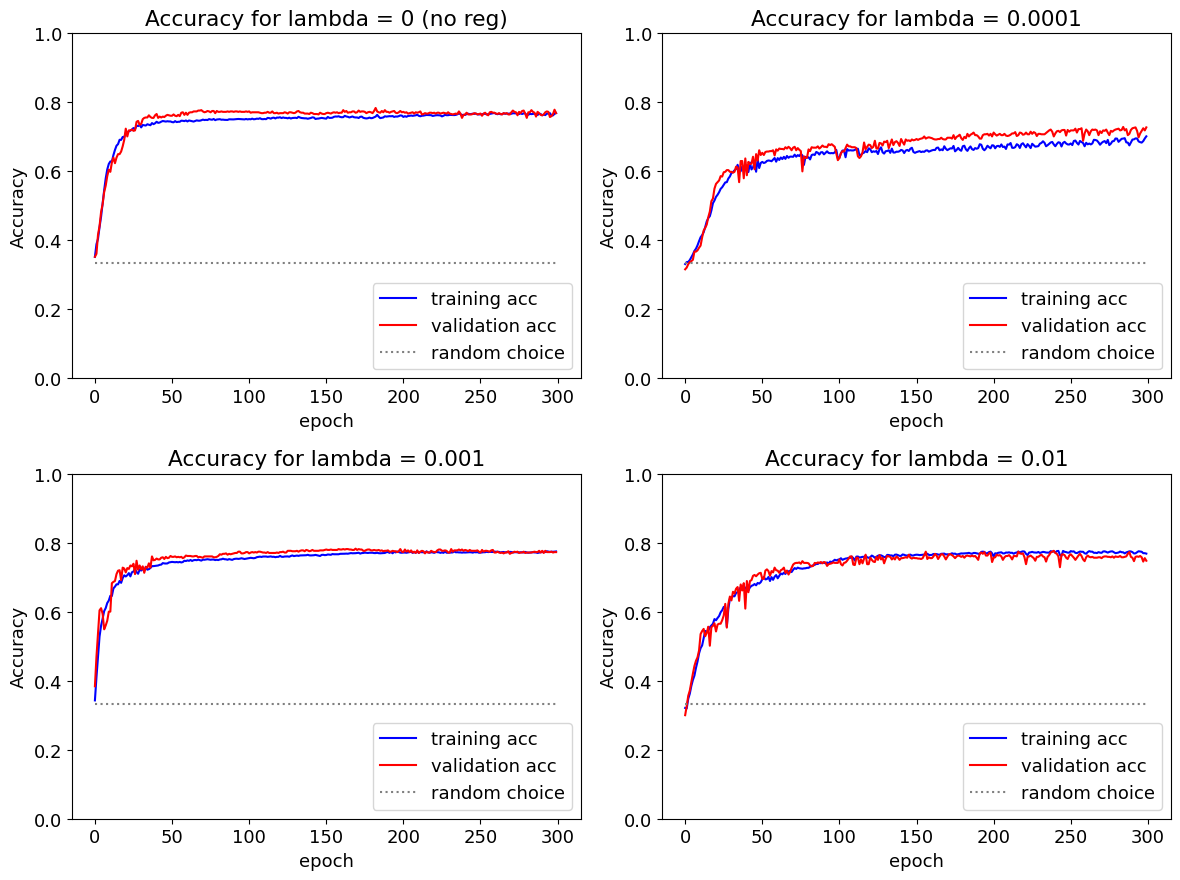

In [42]:
# Introducing the regularization 

best_lr = 0.0875 # value obtained by observing the previous plot
lamb = [0, 10e-5, 10e-4, 10e-3]

BATCH_SIZE = 200
EPOCHS = 300

fig = plt.figure(figsize = (12, 9))

LAMBDA = {}

for k, i in enumerate(lamb):
    ax = fig.add_subplot(2,2,k+1)
    
    LAMBDA[(i)] = []
    model2 = keras.models.clone_model(model)
    opt2 = get_optimizer('sgd', learning_rate=best_lr)
    model2.compile(loss=keras.losses.categorical_crossentropy, optimizer = opt2, metrics = ['accuracy'])
    fit2 = model2.fit(x_train,y_train,batch_size=BATCH_SIZE,epochs=EPOCHS,validation_data=(x_val, y_val), verbose=0, shuffle=True)
    reg2 = keras.regularizers.l2(i)
    model2.layers[0].kernel_regularizer = reg2
    model2.layers[1].kernel_regularizer = reg2
    model2.layers[2].kernel_regularizer = reg2
    #fit2 = model2.fit(x_train,y_train,batch_size=BATCH_SIZE,epochs=EPOCHS,validation_data=(x_val, y_val), verbose=0, shuffle=True)
    
    ax.plot(fit2.history['accuracy'],"b",label="training acc")
    ax.plot(fit2.history['val_accuracy'],"r",label="validation acc")
    ax.plot((0,EPOCHS),(1/3,1/3),":",c="gray",label="random choice")

    if i==0:
        ax.set_title(f"Accuracy for lambda = {i} (no reg)")
    if i>0:
        ax.set_title(f"Accuracy for lambda = {i}")
    ax.set_xlabel('epoch')
    ax.set_ylabel("Accuracy")
    ax.set_ylim([0, 1])
    ax.legend(loc='lower right')

    LAMBDA[(i)].append([fit2.history['accuracy'][-5:], fit2.history['val_accuracy'][-5:]])

plt.tight_layout()
plt.show()

We find the best value for lambda by determining which plot has the highest final validation accuracy. To avoid our calculations being subjected to random fluctuations of the single final value, we take the last 5 epochs and compute the mean accuracy.

In [44]:
val_acc_lamb = [np.mean(LAMBDA[i][0][1]) for i in lamb]
best_lamb = lamb[np.argmax(val_acc_lamb)]

print(f'Best value for the regularization parameter:  {best_lamb:.4f}')

Best value for the regularization parameter:  0.0010


It can be noted from the following graphs that for some configurations of the kernel size and number of features (specifically NF=6, KS=12), one or two filters appear to be similar to the patterns that we are looking for. This is not a general behaviour, as other configurations of the two hyperparameters do not yield the expected results.

NF=3	 KS=9



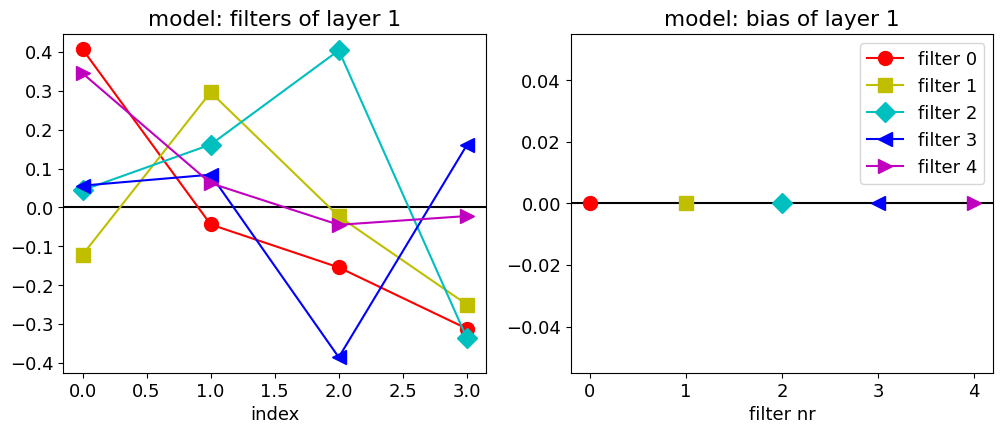

NF=3	 KS=10



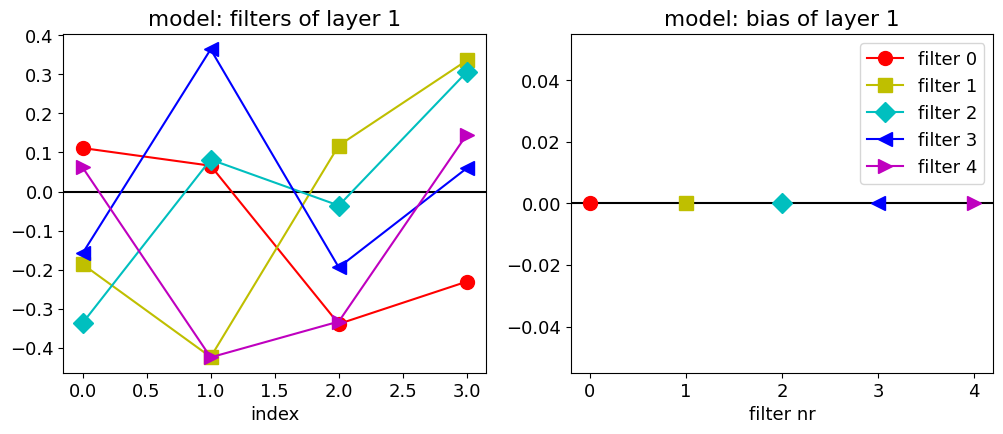

NF=3	 KS=11



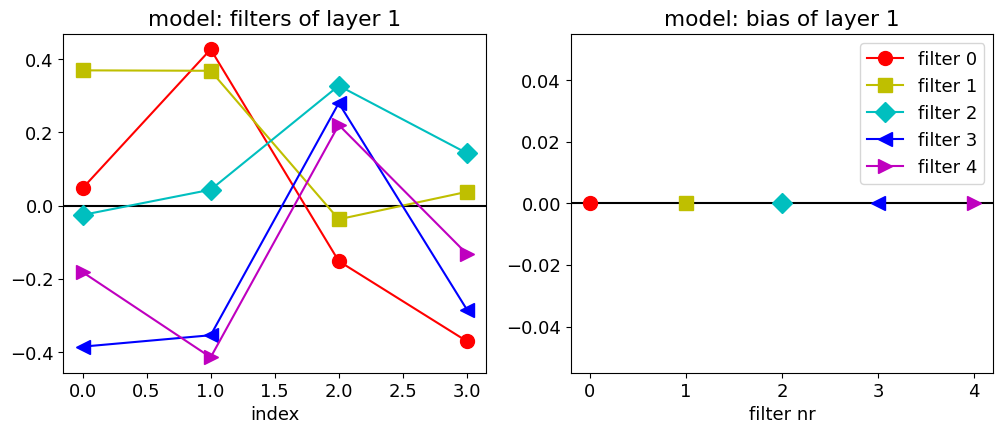

NF=3	 KS=12



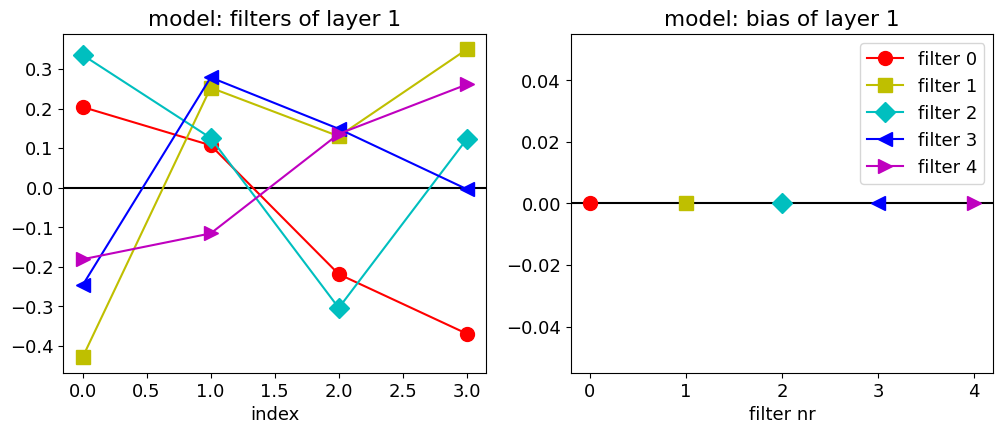

NF=3	 KS=13



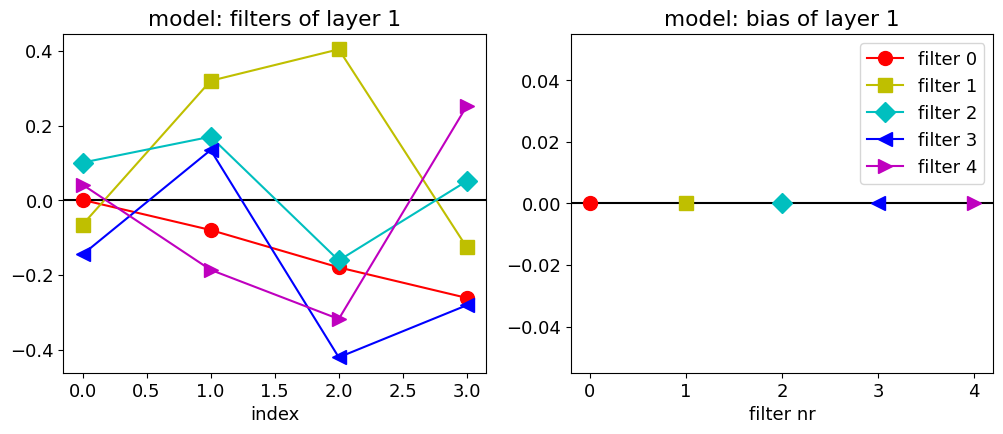

NF=4	 KS=9



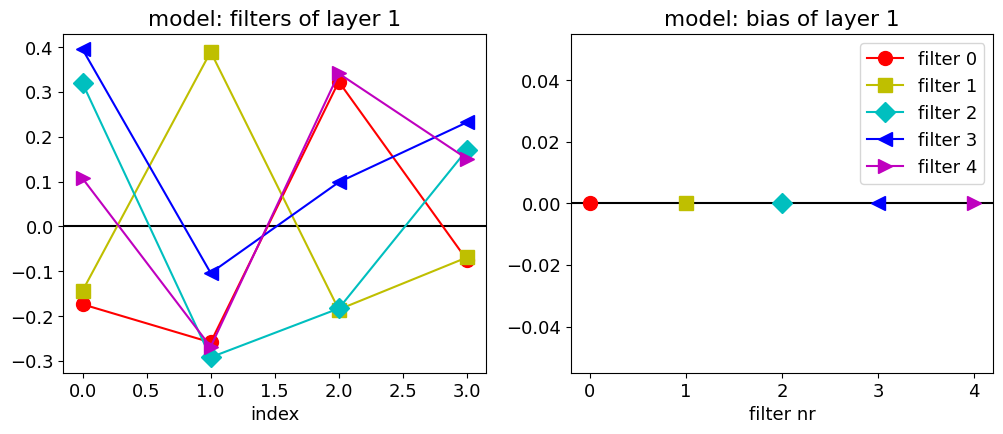

NF=4	 KS=10



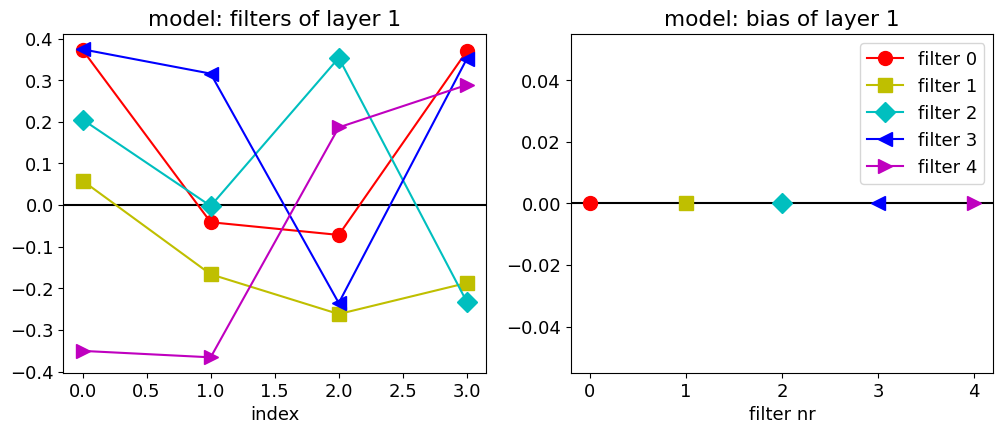

NF=4	 KS=11



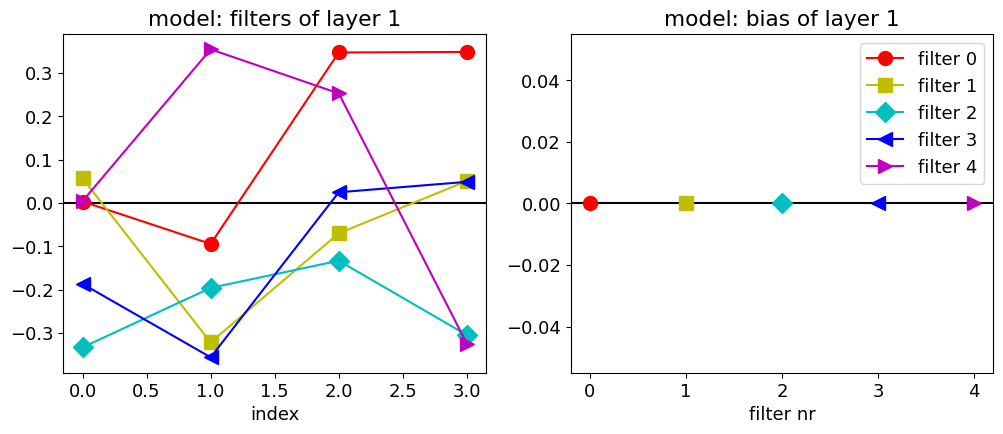

NF=4	 KS=12



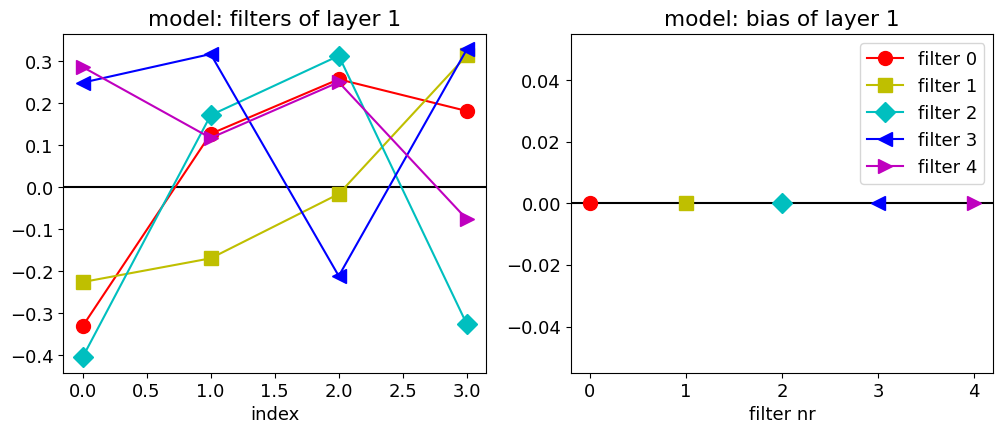

NF=4	 KS=13



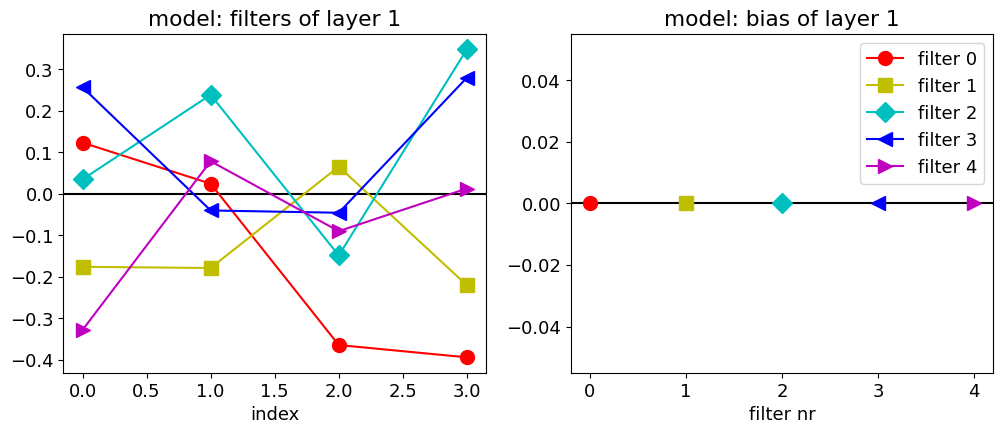

NF=5	 KS=9



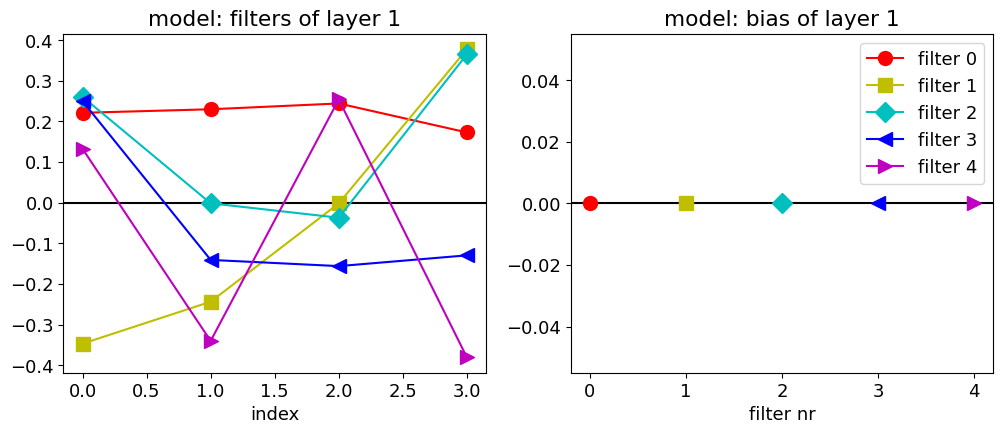

NF=5	 KS=10



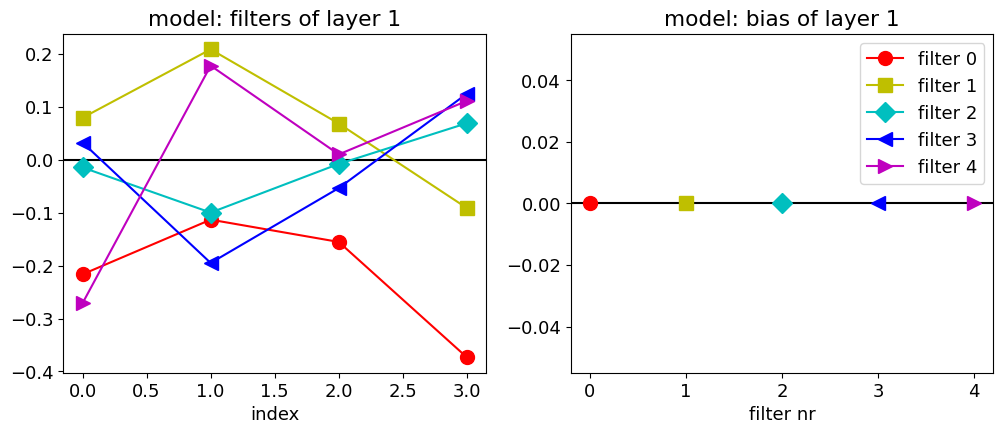

NF=5	 KS=11



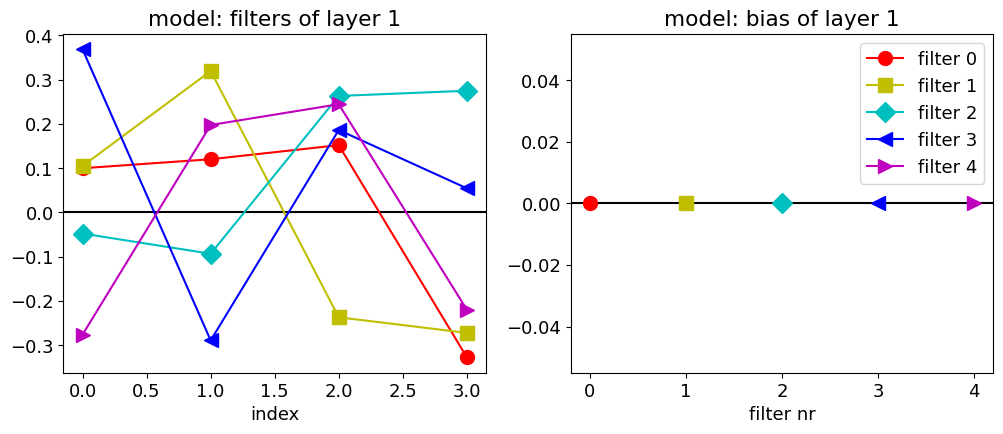

NF=5	 KS=12



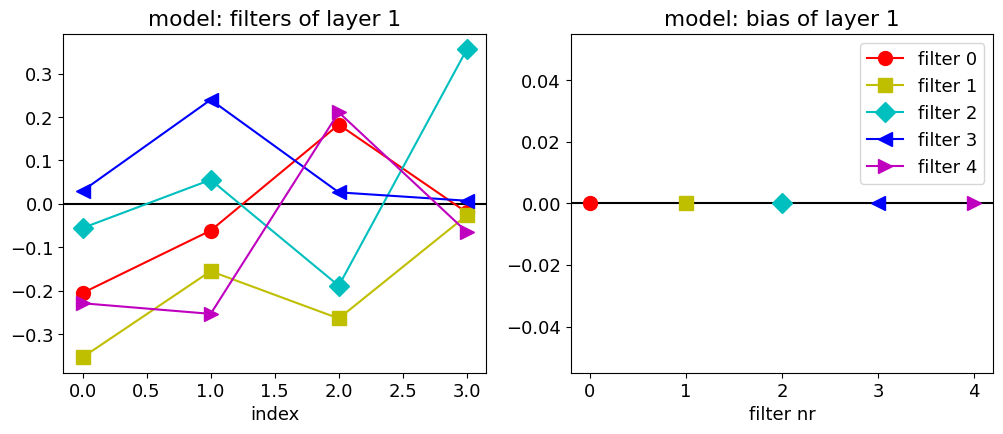

NF=5	 KS=13



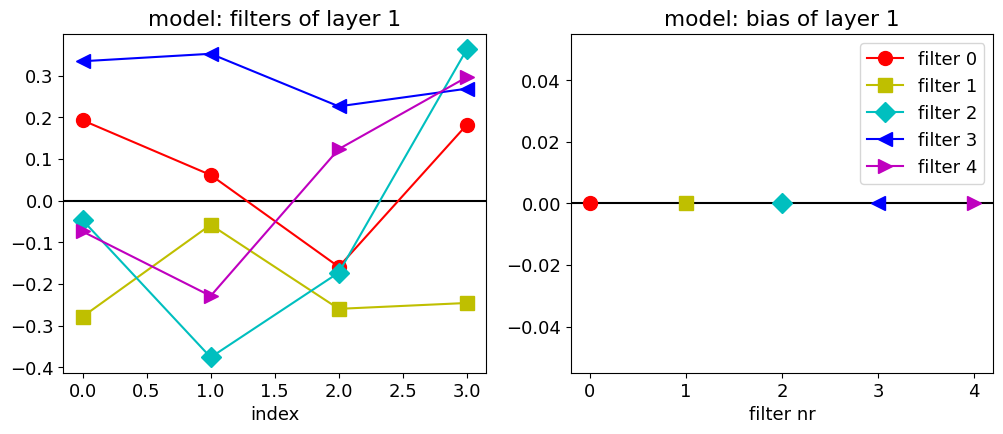

NF=6	 KS=9



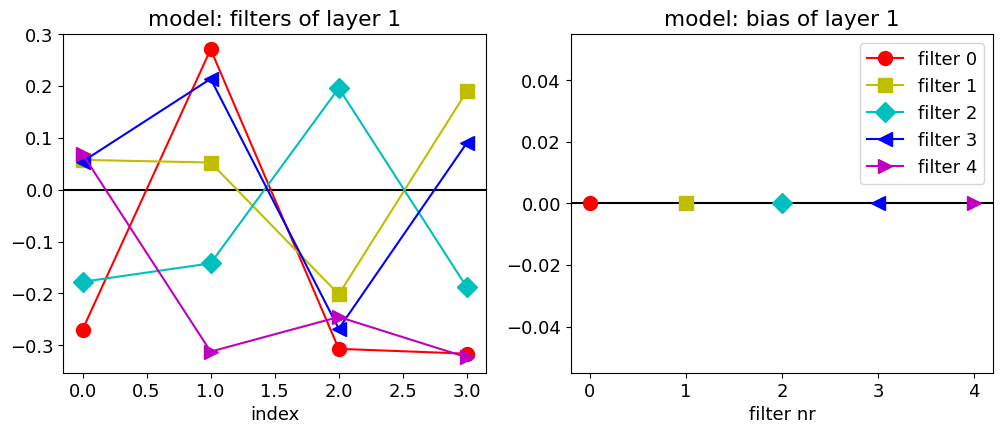

NF=6	 KS=10



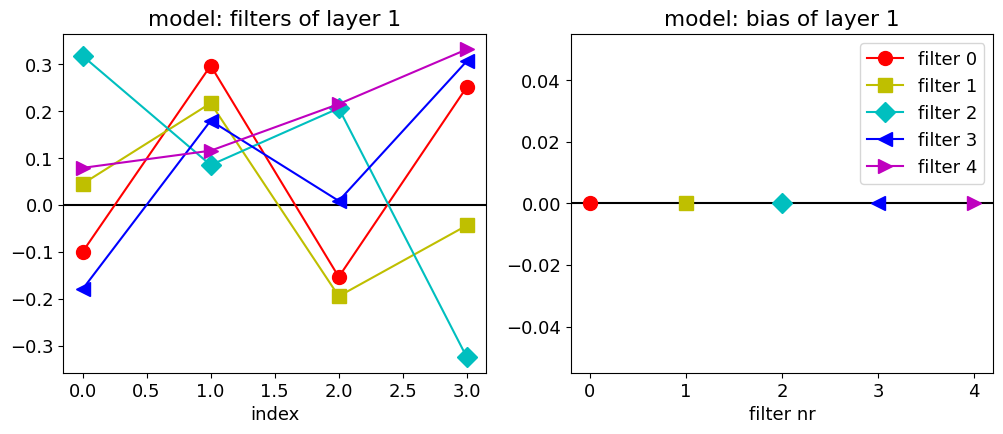

NF=6	 KS=11



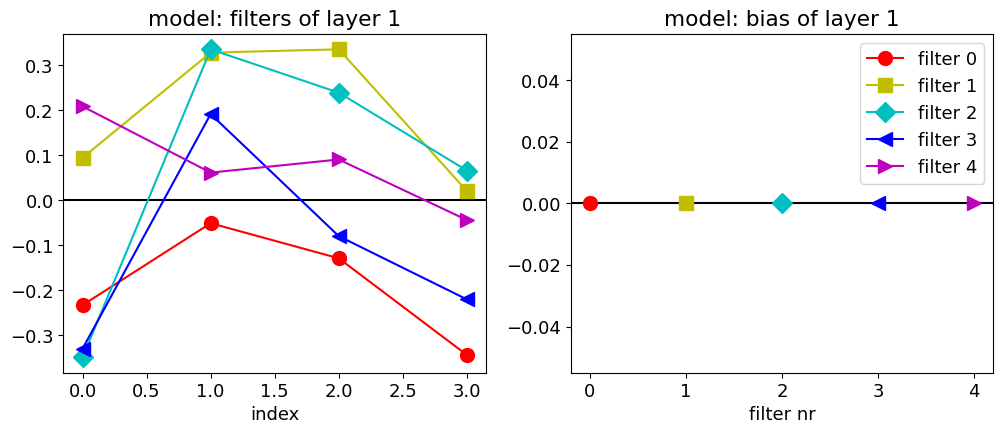

NF=6	 KS=12



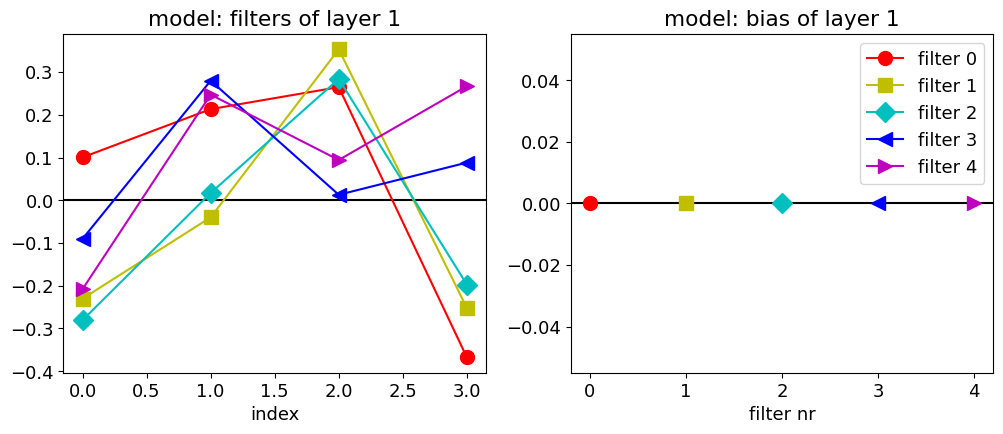

NF=6	 KS=13



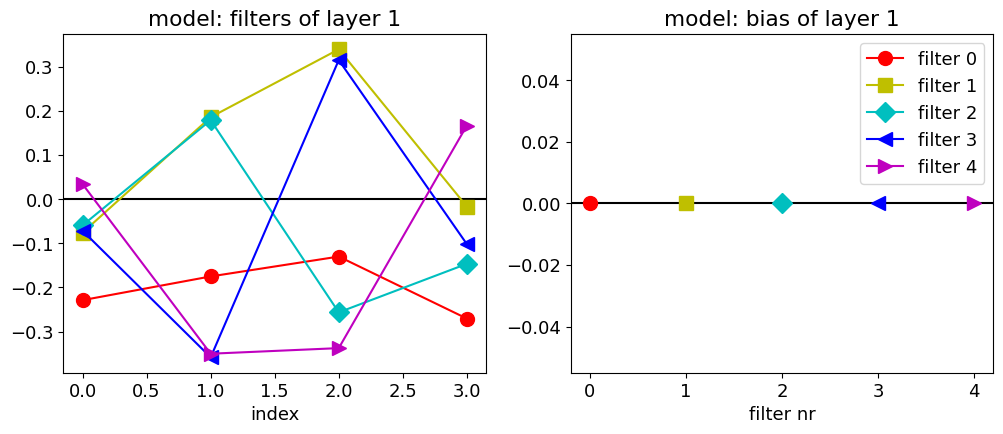

NF=7	 KS=9



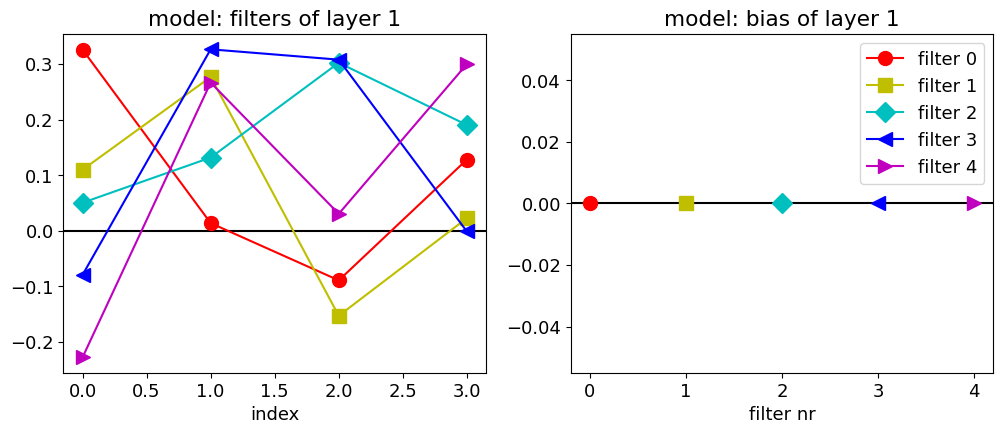

NF=7	 KS=10



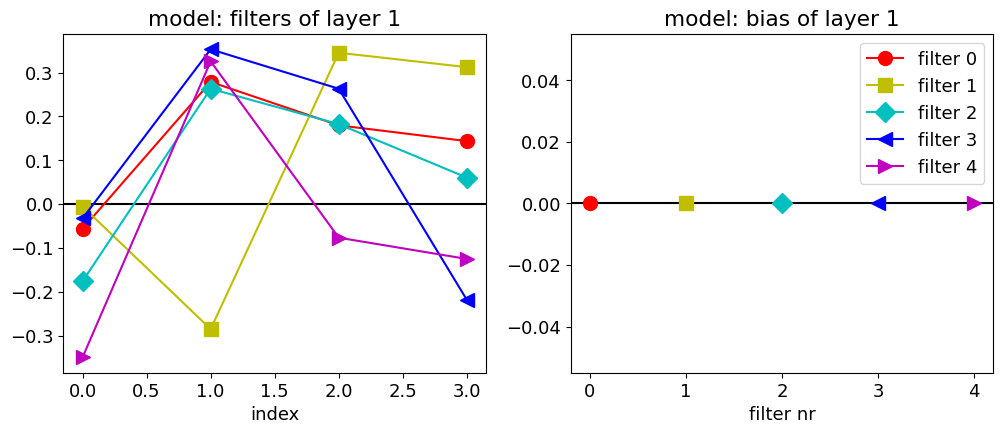

NF=7	 KS=11



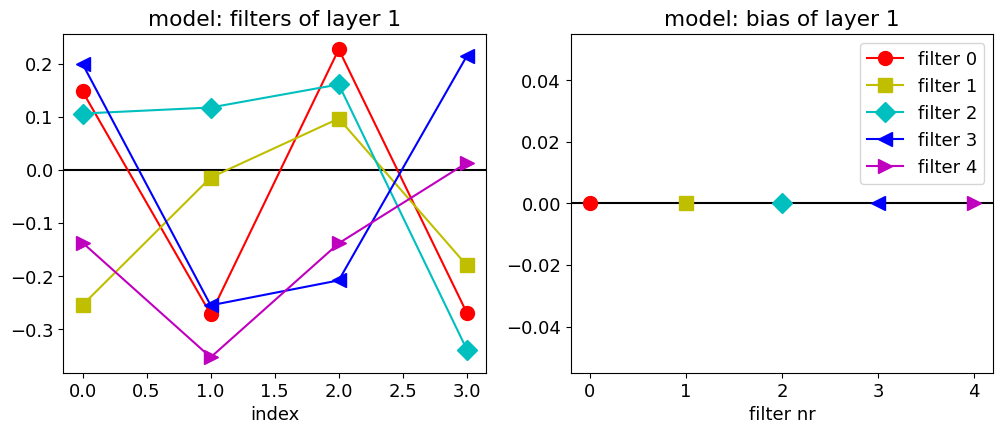

NF=7	 KS=12



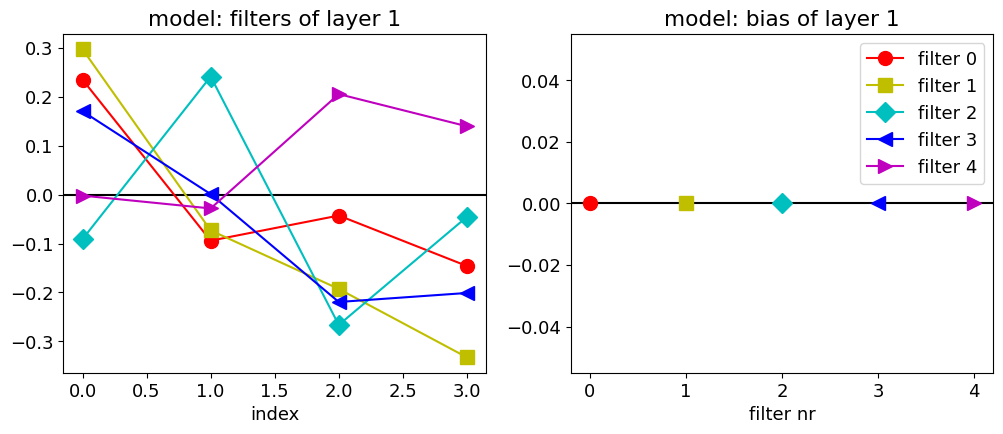

NF=7	 KS=13



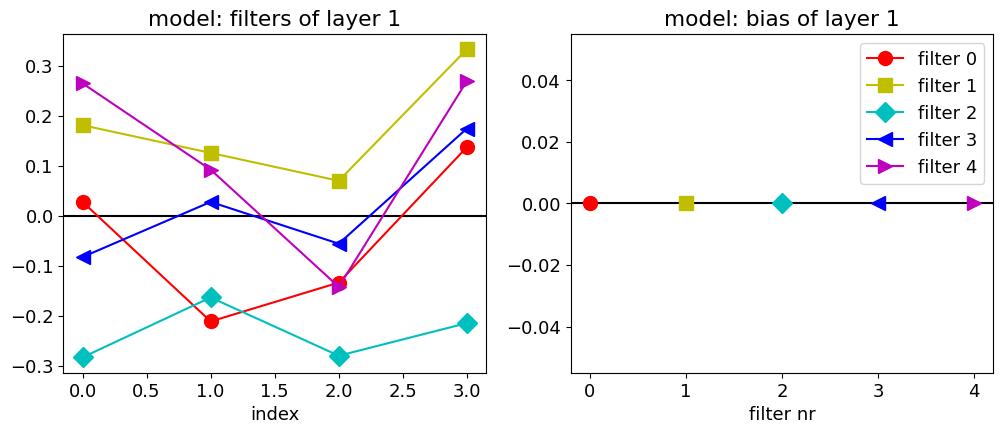

In [51]:
KS = [9, 10, 11, 12, 13] # kernel size
NF = [3, 4, 5, 6, 7] # number filters

for im in NF:
    for jk in KS:
        print('NF='+str(im)+'\t KS='+str(jk))
        model = build_model(NCONV = 2, NF = im, KS = jk)
        opt3 = get_optimizer('nadam', learning_rate=best_lr)

        reg2 = keras.regularizers.l2(best_lamb)
        model.layers[0].kernel_regularizer = reg2
        model.layers[1].kernel_regularizer = reg2
        model.layers[2].kernel_regularizer = reg2

        model.compile(loss=keras.losses.categorical_crossentropy, optimizer=opt,metrics=['accuracy'])

        Show_weights(model,1)
        plt.show()

# Section "Extra"

OPTIMIZER:  RMSPROP
Learning rate: 0.00050 (Run: 1)
Learning rate: 0.00287 (Run: 1)
Learning rate: 0.00525 (Run: 1)
Learning rate: 0.00762 (Run: 1)
Learning rate: 0.01000 (Run: 1)


<Figure size 2000x500 with 0 Axes>

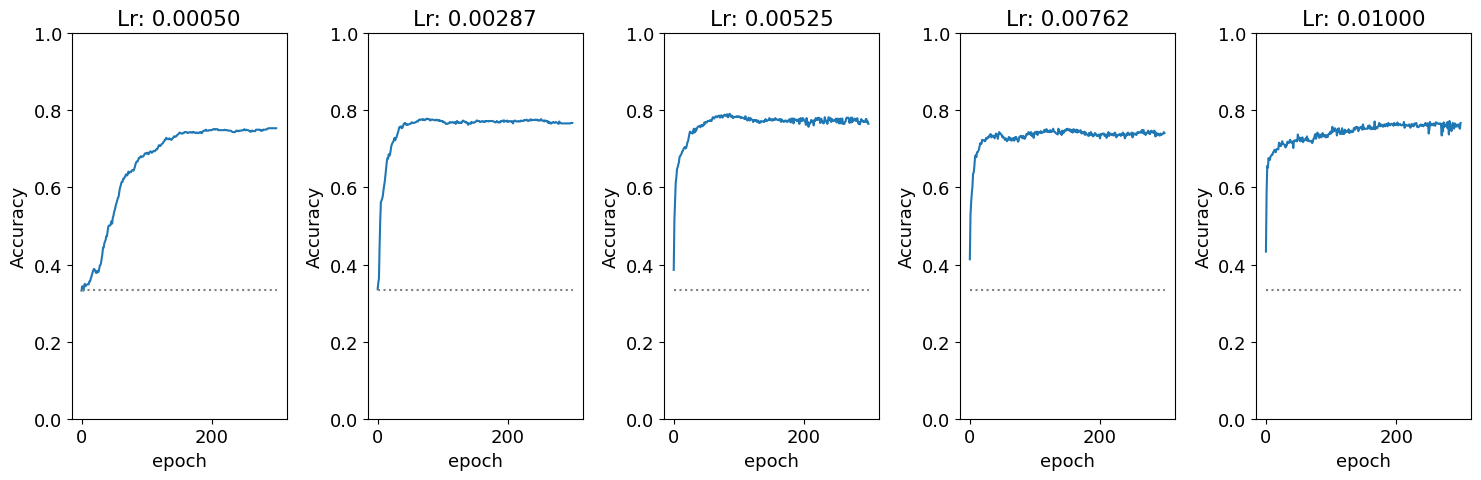

In [19]:
def get_optimizer(optimizer_type, learning_rate):
    if optimizer_type.lower() == 'adam':
        return Adam(learning_rate = learning_rate)
    
    if optimizer_type.lower() == 'rmsprop':
        return RMSprop(learning_rate=learning_rate)
    
    if optimizer_type.lower() == 'nadam':
        return Nadam(learning_rate=learning_rate)
    
    if optimizer_type.lower() == 'sgd':
        return SGD(learning_rate=learning_rate)
    
#OPTIMIZERS = ['adam', 'rmsprop', 'nadam', 'sgd']
OPTIMIZERS = ['rmsprop']

BATCH_SIZE = 200
EPOCHS = 300

N_run = 1
fig = plt.figure(figsize = (20,5))
model=build_model(NCONV=2,KS=11)


fig = plt.figure(figsize = (15, 5))

val_tot = np.zeros(EPOCHS)

etas_tot = [np.linspace(0.0005, 0.01, 5)] * 4 #imposto questo valore per ora 


for j, opt_ in enumerate(OPTIMIZERS):
    print('OPTIMIZER: ', opt_.upper())
    

    for m, e in enumerate(etas_tot[j]):
        
        ax = fig.add_subplot(1, 5, m + 1)
        val_tot = np.zeros(EPOCHS)

        for i in range(N_run):
            model_i = keras.models.clone_model(model)
            #opt = keras.optimizers.Adam(learning_rate = e)
            opt = get_optimizer(opt_, learning_rate=e)

            model_i.compile(loss=keras.losses.categorical_crossentropy, optimizer = opt, metrics = ['accuracy'])
            fit = model_i.fit(x_train,y_train,batch_size=BATCH_SIZE,epochs=EPOCHS,validation_data=(x_val, y_val), verbose=0, shuffle=True)
        
            val_tot += np.array(fit.history['val_accuracy'])
            print(f"Learning rate: {e:.5f} (Run: {i+1})")
            
        ax.plot(val_tot,label=f"eta = {e:.2e}")
        ax.plot((0,EPOCHS),(1/3,1/3),":",c="gray")
        ax.set_title(f'Lr: {e:.5f}')
        ax.set_xlabel('epoch')
        ax.set_ylabel("Accuracy")
        ax.set_ylim([0, 1])

        val_tot = [v / N_run for v in val_tot]

       
    
        
        #ax.legend()

plt.tight_layout()
plt.show()

OPTIMIZER:  ADAM
Learning rate: 0.00050 (Run: 1)
Learning rate: 0.00287 (Run: 1)
Learning rate: 0.00525 (Run: 1)
Learning rate: 0.00762 (Run: 1)
Learning rate: 0.01000 (Run: 1)


<Figure size 2000x500 with 0 Axes>

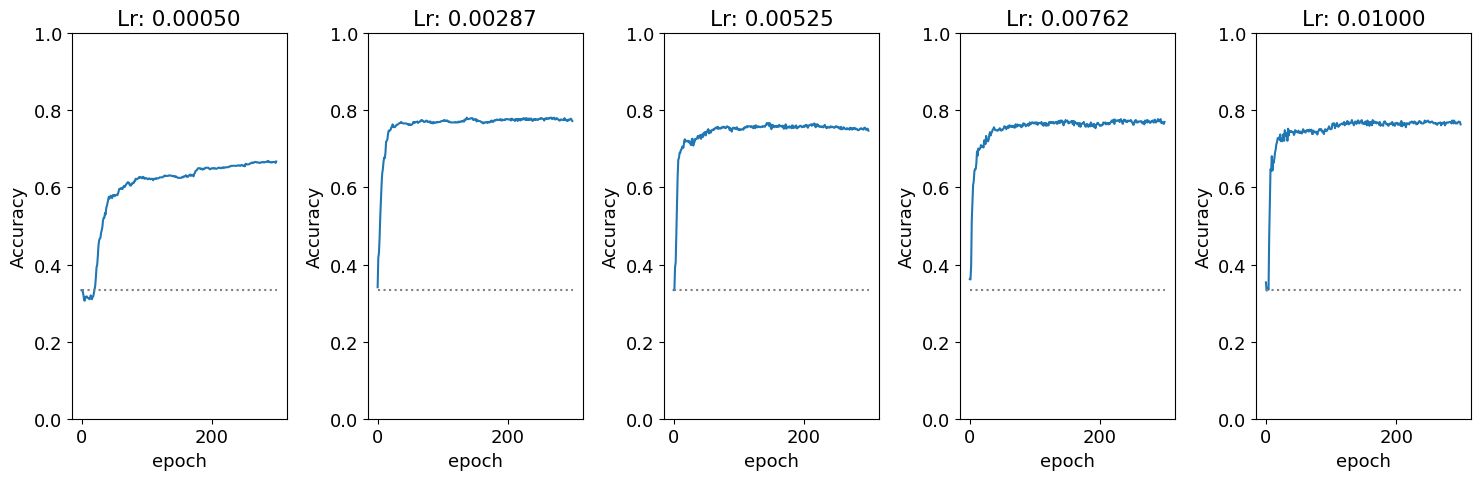

In [20]:
def get_optimizer(optimizer_type, learning_rate):
    if optimizer_type.lower() == 'adam':
        return Adam(learning_rate = learning_rate)
    
    if optimizer_type.lower() == 'rmsprop':
        return RMSprop(learning_rate=learning_rate)
    
    if optimizer_type.lower() == 'nadam':
        return Nadam(learning_rate=learning_rate)
    
    if optimizer_type.lower() == 'sgd':
        return SGD(learning_rate=learning_rate)
    
#OPTIMIZERS = ['adam', 'rmsprop', 'nadam', 'sgd']
OPTIMIZERS = ['adam']

BATCH_SIZE = 200
EPOCHS = 300

N_run = 1
fig = plt.figure(figsize = (20,5))
model=build_model(NCONV=2,KS=11)


fig = plt.figure(figsize = (15, 5))

val_tot = np.zeros(EPOCHS)

etas_tot = [np.linspace(0.0005, 0.01, 5)] * 4 #imposto questo valore per ora 


for j, opt_ in enumerate(OPTIMIZERS):
    print('OPTIMIZER: ', opt_.upper())
    

    for m, e in enumerate(etas_tot[j]):
        
        ax = fig.add_subplot(1, 5, m + 1)
        val_tot = np.zeros(EPOCHS)

        for i in range(N_run):
            model_i = keras.models.clone_model(model)
            #opt = keras.optimizers.Adam(learning_rate = e)
            opt = get_optimizer(opt_, learning_rate=e)

            model_i.compile(loss=keras.losses.categorical_crossentropy, optimizer = opt, metrics = ['accuracy'])
            fit = model_i.fit(x_train,y_train,batch_size=BATCH_SIZE,epochs=EPOCHS,validation_data=(x_val, y_val), verbose=0, shuffle=True)
        
            val_tot += np.array(fit.history['val_accuracy'])
            print(f"Learning rate: {e:.5f} (Run: {i+1})")
            
        ax.plot(val_tot,label=f"eta = {e:.2e}")
        ax.plot((0,EPOCHS),(1/3,1/3),":",c="gray")
        ax.set_title(f'Lr: {e:.5f}')
        ax.set_xlabel('epoch')
        ax.set_ylabel("Accuracy")
        ax.set_ylim([0, 1])

        val_tot = [v / N_run for v in val_tot]

plt.tight_layout()
plt.show()

OPTIMIZER:  NADAM
Learning rate: 0.00050 (Run: 1)
Learning rate: 0.00262 (Run: 1)
Learning rate: 0.00475 (Run: 1)
Learning rate: 0.00687 (Run: 1)
Learning rate: 0.00900 (Run: 1)


<Figure size 2000x500 with 0 Axes>

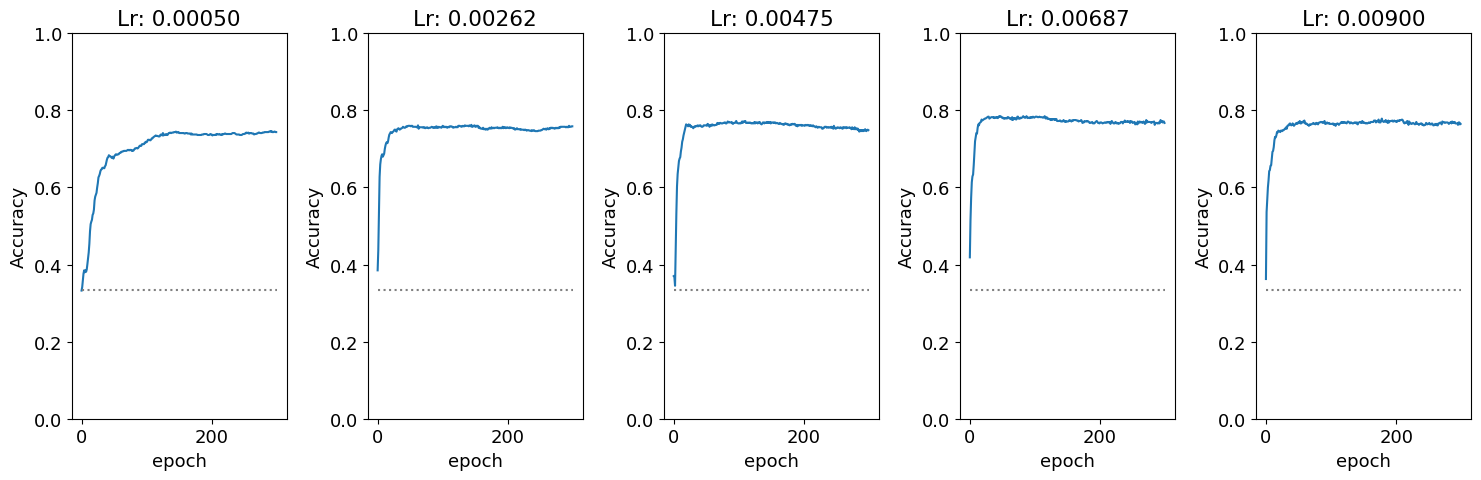

In [21]:
def get_optimizer(optimizer_type, learning_rate):
    if optimizer_type.lower() == 'adam':
        return Adam(learning_rate = learning_rate)
    
    if optimizer_type.lower() == 'rmsprop':
        return RMSprop(learning_rate=learning_rate)
    
    if optimizer_type.lower() == 'nadam':
        return Nadam(learning_rate=learning_rate)
    
    if optimizer_type.lower() == 'sgd':
        return SGD(learning_rate=learning_rate)
    
#OPTIMIZERS = ['adam', 'rmsprop', 'nadam', 'sgd']
OPTIMIZERS = ['nadam']

BATCH_SIZE = 200
EPOCHS = 300

N_run = 1
fig = plt.figure(figsize = (20,5))
model=build_model(NCONV=2,KS=11)


fig = plt.figure(figsize = (15, 5))

val_tot = np.zeros(EPOCHS)

etas_tot = [np.linspace(0.0005, 0.009, 5)] * 4 #imposto questo valore per ora 


for j, opt_ in enumerate(OPTIMIZERS):
    print('OPTIMIZER: ', opt_.upper())
    

    for m, e in enumerate(etas_tot[j]):
        
        ax = fig.add_subplot(1, 5, m + 1)
        val_tot = np.zeros(EPOCHS)

        for i in range(N_run):
            model_i = keras.models.clone_model(model)
            #opt = keras.optimizers.Adam(learning_rate = e)
            opt = get_optimizer(opt_, learning_rate=e)

            model_i.compile(loss=keras.losses.categorical_crossentropy, optimizer = opt, metrics = ['accuracy'])
            fit = model_i.fit(x_train,y_train,batch_size=BATCH_SIZE,epochs=EPOCHS,validation_data=(x_val, y_val), verbose=0, shuffle=True)
        
            val_tot += np.array(fit.history['val_accuracy'])
            print(f"Learning rate: {e:.5f} (Run: {i+1})")
            
        ax.plot(val_tot,label=f"eta = {e:.2e}")
        ax.plot((0,EPOCHS),(1/3,1/3),":",c="gray")
        ax.set_title(f'Lr: {e:.5f}')
        ax.set_xlabel('epoch')
        ax.set_ylabel("Accuracy")
        ax.set_ylim([0, 1])

        val_tot = [v / N_run for v in val_tot]

plt.tight_layout()
plt.show()

OPTIMIZER:  SGD
Learning rate: 0.05000 (Run: 1)
Learning rate: 0.05000 (Run: 2)
Learning rate: 0.05000 (Run: 3)
Learning rate: 0.05000 (Run: 4)
Learning rate: 0.05000 (Run: 5)
Learning rate: 0.06250 (Run: 1)
Learning rate: 0.06250 (Run: 2)
Learning rate: 0.06250 (Run: 3)
Learning rate: 0.06250 (Run: 4)
Learning rate: 0.06250 (Run: 5)
Learning rate: 0.07500 (Run: 1)
Learning rate: 0.07500 (Run: 2)
Learning rate: 0.07500 (Run: 3)
Learning rate: 0.07500 (Run: 4)
Learning rate: 0.07500 (Run: 5)
Learning rate: 0.08750 (Run: 1)
Learning rate: 0.08750 (Run: 2)
Learning rate: 0.08750 (Run: 3)
Learning rate: 0.08750 (Run: 4)
Learning rate: 0.08750 (Run: 5)
Learning rate: 0.10000 (Run: 1)
Learning rate: 0.10000 (Run: 2)
Learning rate: 0.10000 (Run: 3)
Learning rate: 0.10000 (Run: 4)
Learning rate: 0.10000 (Run: 5)


<Figure size 2000x500 with 0 Axes>

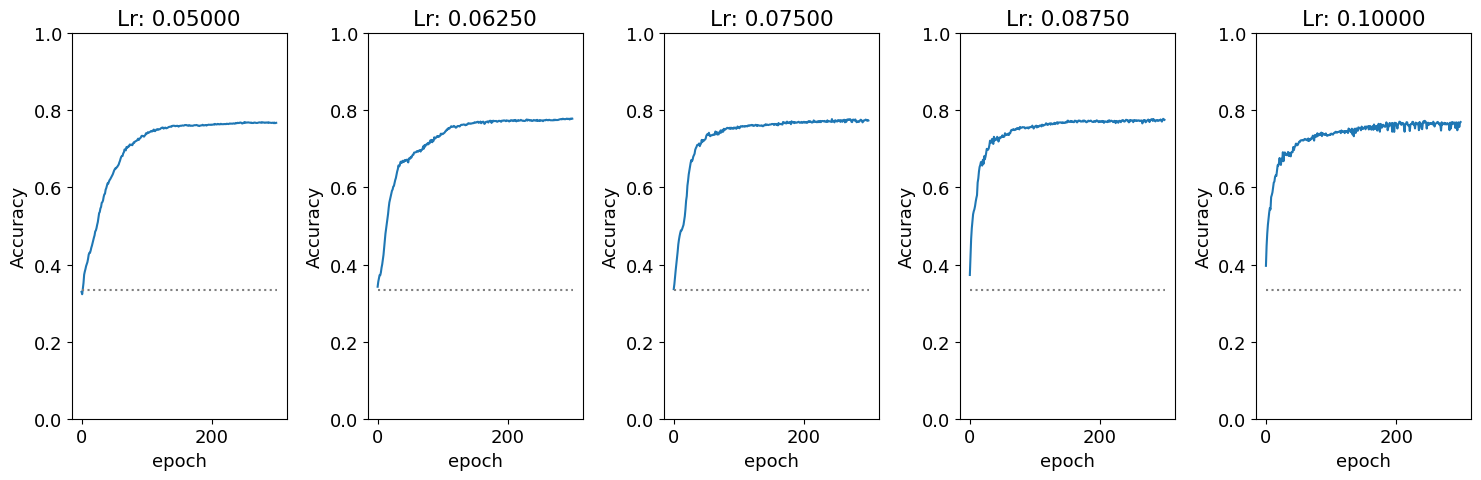

In [22]:
def get_optimizer(optimizer_type, learning_rate):
    if optimizer_type.lower() == 'adam':
        return Adam(learning_rate = learning_rate)
    
    if optimizer_type.lower() == 'rmsprop':
        return RMSprop(learning_rate=learning_rate)
    
    if optimizer_type.lower() == 'nadam':
        return Nadam(learning_rate=learning_rate)
    
    if optimizer_type.lower() == 'sgd':
        return SGD(learning_rate=learning_rate)
    
#OPTIMIZERS = ['adam', 'rmsprop', 'nadam', 'sgd']
OPTIMIZERS = ['sgd']

BATCH_SIZE = 200
EPOCHS = 300

N_run = 5
fig = plt.figure(figsize = (20,5))
model=build_model(NCONV=2,KS=11)


fig = plt.figure(figsize = (15, 5))

val_tot = np.zeros(EPOCHS)

etas_tot = [np.linspace(0.05, 0.1, 5)] * 4 #imposto questo valore per ora 


for j, opt_ in enumerate(OPTIMIZERS):
    print('OPTIMIZER: ', opt_.upper())
    

    for m, e in enumerate(etas_tot[j]):
        
        ax = fig.add_subplot(1, 5, m + 1)
        val_tot = np.zeros(EPOCHS)

        for i in range(N_run):
            model_i = keras.models.clone_model(model)
            #opt = keras.optimizers.Adam(learning_rate = e)
            opt = get_optimizer(opt_, learning_rate=e)

            model_i.compile(loss=keras.losses.categorical_crossentr opy, optimizer = opt, metrics = ['accuracy'])
            fit = model_i.fit(x_train,y_train,batch_size=BATCH_SIZE,epochs=EPOCHS,validation_data=(x_val, y_val), verbose=0, shuffle=True)
        
            val_tot += np.array(fit.history['val_accuracy'])
            print(f"Learning rate: {e:.5f} (Run: {i+1})")
        
        val_tot = [v / N_run for v in val_tot]
        
        ax.plot(val_tot,label=f"eta = {e:.2e}")
        ax.plot((0,EPOCHS),(1/3,1/3),":",c="gray")
        ax.set_title(f'Lr: {e:.5f}')
        ax.set_xlabel('epoch')
        ax.set_ylabel("Accuracy")
        ax.set_ylim([0, 1])

plt.tight_layout()
plt.show()